# Example of plotting the predictions

In the first cell you first find the code that was in the generate_model_output.py, so that we get the predicitons. In the cell after you load in the colormap and the cell after shows an example of how to plot it with coordinates.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 18 20:27:53 2022

@author: Diewertje
"""
import pandas as pd
import numpy as np
import torch
import os

from nowcasting.config import cfg
from nowcasting.models.encoder import Encoder
from nowcasting.models.forecaster import Forecaster
from nowcasting.net_params import encoder_params, forecaster_params
from nowcasting.models.model import EF
from nowcasting.utils import pixel_to_rainfall
from nowcasting.image import quick_read_frames


def generate_output_model(start_datetime, data_dir, model_name = "all_data_balanced_loss_iteration100", iteration_number = 68000, pixel_type='normalised pixel values'):
    """
    input: 
        start_datetime:   The date of the start of the 5 frames that you need for the prediction. 
                          So this is your t-20 min. 
                          A string, for example: '2018-06-01 13:35:00'
        data_dir:         The path to the directory where you store the data
        model_name:       String withthe name of the folder where the model can be found. 
                          For example: "all_data_balanced_loss_iteration100" 
                          (This is the one you will be working with for now)
        iteration number: Integer to specify from which iteration you want the model. for example 68000
        pixel_type:       The type of pixel values the model is trained on. 
    
    Output: 
            fc:           The forecast for 20 frames in the future (shape=20x480x480) 
            test_data:    The 5 frames you used for the forecast
    """

    # Initialise the encoder_forecaster
    encoder = Encoder(encoder_params[0], encoder_params[1]).to(cfg.GLOBAL.DEVICE)
    forecaster = Forecaster(forecaster_params[0], forecaster_params[1])
    encoder_forecaster = EF(encoder, forecaster).to(cfg.GLOBAL.DEVICE)

    # Load in the trained model
    encoder_forecaster.load_state_dict(torch.load(f"{model_name}/models/encoder_forecaster_{iteration_number}.pth", map_location=torch.device(cfg.GLOBAL.DEVICE)))

    # Load in some constants from the config.py file
    IN_LEN = cfg.HKO.BENCHMARK.IN_LEN
    SEQ_LEN = cfg.HKO.BENCHMARK.SEQ_LEN
    SCALE_FACTOR = cfg.GLOBAL.NORMALIZE

    # Load in the data, which are given in pixel values between 0-255 -> dBZ = value*0.5 - 32
    datetime_clip = pd.date_range(start=start_datetime, periods=SEQ_LEN, freq='5min')
    test_batch = load_frames(datetime_clip, data_dir)

    if pixel_type == 'normalised pixel values':
        test_batch = test_batch.astype(np.float32) / SCALE_FACTOR 
    if pixel_type == 'rainfall rates':
        test_batch = pixel_to_rainfall(test_batch.astype(np.float32))
        
    test_data = test_batch[:IN_LEN, ...]
    torch_test_data = torch.from_numpy(test_data).to(cfg.GLOBAL.DEVICE)

    # calculate output
    with torch.no_grad():
        output = encoder_forecaster(torch_test_data)

    if pixel_type == 'normalised pixel values':
        fc = pixel_to_rainfall(output[:,0,0,:,:]*SCALE_FACTOR)
        test_data = pixel_to_rainfall(test_data*SCALE_FACTOR)
    if pixel_type == 'rainfall rates':
        fc = output[:, 0, 0, :, :]

    return fc, test_data # these values are rainfall rates, for both type of models.

# Since the iterator does not work with the data that I downloaded for some reason, call function separately:
def load_frames(datetime_clips, data_dir):
    """
    In the original function in Eva's dataloader.py, it takes in batchsize=2.
    bus since I now have batchsize is 1, datetime_clips is just 1 list with dates instead of 2.
    therefore, clip is already the datetime that we are interested in.
    the paths is only for if you have batchsize bigger than 1.
    """
    frame_dat = np.zeros((cfg.HKO.BENCHMARK.SEQ_LEN, 1, 1, 480, 480))
    for i, clip in enumerate(datetime_clips):
        path = []
        path = convert_datetime_to_filepath(clip, data_dir)
        frames = quick_read_frames([path]) # I have it now as [path], since quick_read_frames takes the 0th element in it and withouth the list breackets it only reads the rist letter of the string.
        frame_dat[i, 0, 0, :, :] = frames
    return frame_dat

def convert_datetime_to_filepath(date_time, data_dir):
    """
    Convert datetime to filepath (depends on filetype)

    Parameters
    ----------
    date_time : datetime64

    Returns
    -------
    filepath : str

    """

    # for the radar refl tar archive

    year = "%04d" % date_time.year
    month = "%02d" % date_time.month
    day = "%02d" % date_time.day
    next_day = "%02d" % (date_time.day+1)
    hour = "%02d" % date_time.hour
    minute = "%02d" % date_time.minute

    year_folder = f'{year}'
    day_folder = f'{year}-{month}-{day}'
    file_str = f'RAD_NL25_PCP_NA_{year}{month}{day}{hour}{minute}.h5'

    return os.path.join(data_dir, year_folder, day_folder, file_str)

fc, input_data = generate_output_model('2018-06-01 13:35:00', os.getcwd() + '/data_event_2018/')

0
output device = cpu
It is running on 0 GPUs
indexes=  None


C:\Users\Diewertje\Python\envs\geo_env\lib\site-packages\torch\nn\functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


#### Get the colormap and coordinates

In [2]:
# The colormap:

from pysteps.visualization import precipfields
cmap_pysteps = precipfields.get_colormap('intensity', 'mm/h', colorscale='pysteps')  # other colorscale options: 'STEPS-BE', 'BOM-RF3'

import matplotlib.colors 
# [0.08, 0.16, 0.25, 0.4, 0.63, 0.84, 1, 1.2, 1.4, 1.6, 2, 2.5, 4, 6.3,  10]
new_norm = matplotlib.colors.BoundaryNorm(np.logspace(-2,1, 16),cmap_pysteps[0].N)
new_norm

new_norm2 = matplotlib.colors.BoundaryNorm(np.logspace(-1.3,0.5, 16),cmap_pysteps[0].N)
print(np.logspace(-1.3,1.5,16))

new_norm_30 = matplotlib.colors.BoundaryNorm(np.logspace(-1.3,1.5, 16),cmap_pysteps[0].N)


Pysteps configuration file found at: C:\Users\Diewertje\Python\envs\geo_env\lib\site-packages\pysteps\pystepsrc

[ 0.05011872  0.0770312   0.11839499  0.18197009  0.27968338  0.42986623
  0.66069345  1.01546899  1.56074996  2.39883292  3.68694506  5.66674061
  8.7096359  13.38648842 20.57469156 31.6227766 ]


The KNMI dataset gives images of 700x765 pixels. This covers north south: 55.97 - 48.9 lattitude (in 765 pixels) and West east: 0-10.86 longitude (in 700 pixels). (see KNMI website)

The model takes 480x480 as input, and outputs that as well. (See figure 3.4 of Eva's Thesis).

These are the pixels: YMIN = 141, YMAX = 621, XMIN = 109, XMAX = 589

That means that the image goes from:  YMIN = 54.67 lat, YMAX = 50.23, XMIN = 1.69, XMAX = 9.14


In [3]:
# Calculate the latitude
55.97- (55.97-48.9)/765*621

50.230823529411765

In [4]:
# Calculate the longitude
0 + 10.86/700*589

9.137914285714285

In [5]:
LAT = np.linspace(54.67,50.23,480)
LON = np.linspace(1.69, 9.14, 480)

#### Plot the predictions

In the cell below you find a simple function to plot the frames, and a funciton where automatically 5 of them get plotted for you, as an example of how to use it.

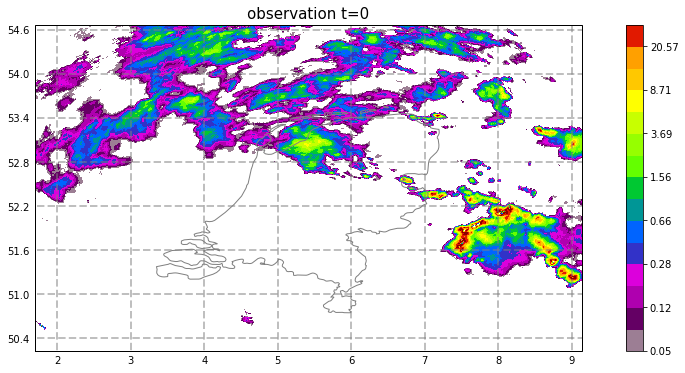

In [6]:
from cartopy.io import shapereader
import numpy as np
import geopandas
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

# get natural earth data (http://www.naturalearthdata.com/)

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shpfilename)

# read the german borders
poly = df.loc[df['ADMIN'] == 'Netherlands']['geometry'].values[0]

def simple_precip_plot(frame, title, norm= new_norm_30, cmap=cmap_pysteps[0]): 
    """
    This function plots the observation or prediction on top of a map of the netherlands, 
    with gridlines indicating the coordinates
    
    frame     = a frame from the forecast or the input data
    title     = the title for the frame you plot, for example: observation t=0, or forecast t=+5 min
    norm norm = type of norm you chose. Can be cmap_pysteps[1] (this is what Eva van der Kooij had used in her thesis,
    I now often use or new_norm_30 to scale to analyse some differences. I do not know yet what I will use in the 
    final maps. Maybe discuss this with Marc?
    cmap      = the colormap: cmap_pysteps[0]
    """
    plt.figure(figsize=(20,6))
    # Plot the map of the netherlands
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', 
                      edgecolor='0.5')
    ax.set_extent([1.69,9.14, 54.67,50.23], crs=ccrs.PlateCarree())
    
    # Get gridlines and coordinates
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    # plot the forecast with colorbar
    fig = plt.imshow(frame, cmap=cmap, norm=norm, extent=[1.69,9.14, 54.67,50.23])
    plt.colorbar(fig, fraction=0.0476, pad=0.04, orientation='vertical')
    
    plt.title(f'{title}', fontsize=15)
    plt.tight_layout()
    plt.show()
    return fig

simple_precip_plot(input_data[4,0,0,:,:], 'observation t=0')